In [57]:
# Portfolio Markowitz Mean Variance Optimisation

# Modern portfolio theory is a theory on how risk-averse investors can construct portfolios to
# maximise expected return based on a given level of market risk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as pdr
from scipy.optimize import Bounds, minimize

## Collecting Data

We will use the following below ETFs for our portfolio, including the a risk free rate of the 3 month treasury bill.

* XLB - Materials Select Sector SPDR Fund
* XLV - Health Care Select Sector SPDR Fund
* XLP - Consumer Staples Select Sector SPDR Fund
* XLY - Consumer Discretionary Select Sector SPDR Fund
* XLE - Energy Select Sector SPDR Fund
* XLF - Financial Select Sector SPDR Fund
* XLI - Industrial Select Sector SPDR Fund
* XLK - Technology Select Sector SPDR Fund
* XLU - Utilities Select Sector SPDR Fund

In [58]:

def asset_Data(tickers: list, start: str, end: str):
    asset_data = yf.download(tickers, start=start, end=end)
    asset_data = pd.DataFrame(asset_data['Adj Close'])
    asset_data.dropna()
    return asset_data

def fred_Data(series_ids: list, start: str, end: str):
    data = pdr.get_data_fred(series_ids, start=start, end=end)
    if data is not None and not data.empty:
        data.index = pd.to_datetime(data.index)
        return data
    else:
        print('No Data Available')
        return pd.DataFrame()

start = '2016-08-10'
end = '2019-08-10'
# Assets of choice for this portfolio will be ETFs
tickers = ['XLB', 'XLV', 'XLP', 'XLY', 'XLE', 'XLF', 'XLI', 'XLK', 'XLU']

# risk-free rates
series_ids = {
    '3MO': 'DGS3MO', # 3-Month Treasury Bill
    '1YR': 'DGS1', # 1-Year Treasury Constant Maturity Rate
    '5YR': 'DGS5', # 5-Year Treasury Constant Maturity Rate
    '10YR': 'DGS10', # 10- Year Treasury Constant Maturity Rate
    }

# Gather the data
fed_data = pd.DataFrame({name: fred_Data(series_id, start, end)[series_id]
                         for name, series_id in series_ids.items()})

asset_data = asset_Data(tickers, start, end)
#fed_data.ffill(inplace=True)

print("\n", asset_data.head())
print(fed_data.head())

[*********************100%***********************]  9 of 9 completed



 Ticker                           XLB        XLE        XLF        XLI  \
Date                                                                    
2016-08-10 00:00:00+00:00  41.251228  47.386620  16.557199  50.308044   
2016-08-11 00:00:00+00:00  41.428989  48.083374  16.591864  50.635727   
2016-08-12 00:00:00+00:00  40.988804  48.350822  16.543329  50.497757   
2016-08-15 00:00:00+00:00  41.403606  48.737915  16.654270  50.834068   
2016-08-16 00:00:00+00:00  41.183506  48.815331  16.612667  50.609863   

Ticker                           XLK        XLP        XLU        XLV  \
Date                                                                    
2016-08-10 00:00:00+00:00  42.736824  43.996937  38.839878  65.001068   
2016-08-11 00:00:00+00:00  42.891430  43.996937  38.931793  65.376045   
2016-08-12 00:00:00+00:00  42.845970  44.149212  38.985416  65.210342   
2016-08-15 00:00:00+00:00  43.055134  44.037014  38.387993  65.323700   
2016-08-16 00:00:00+00:00  42.736824  43.844673 

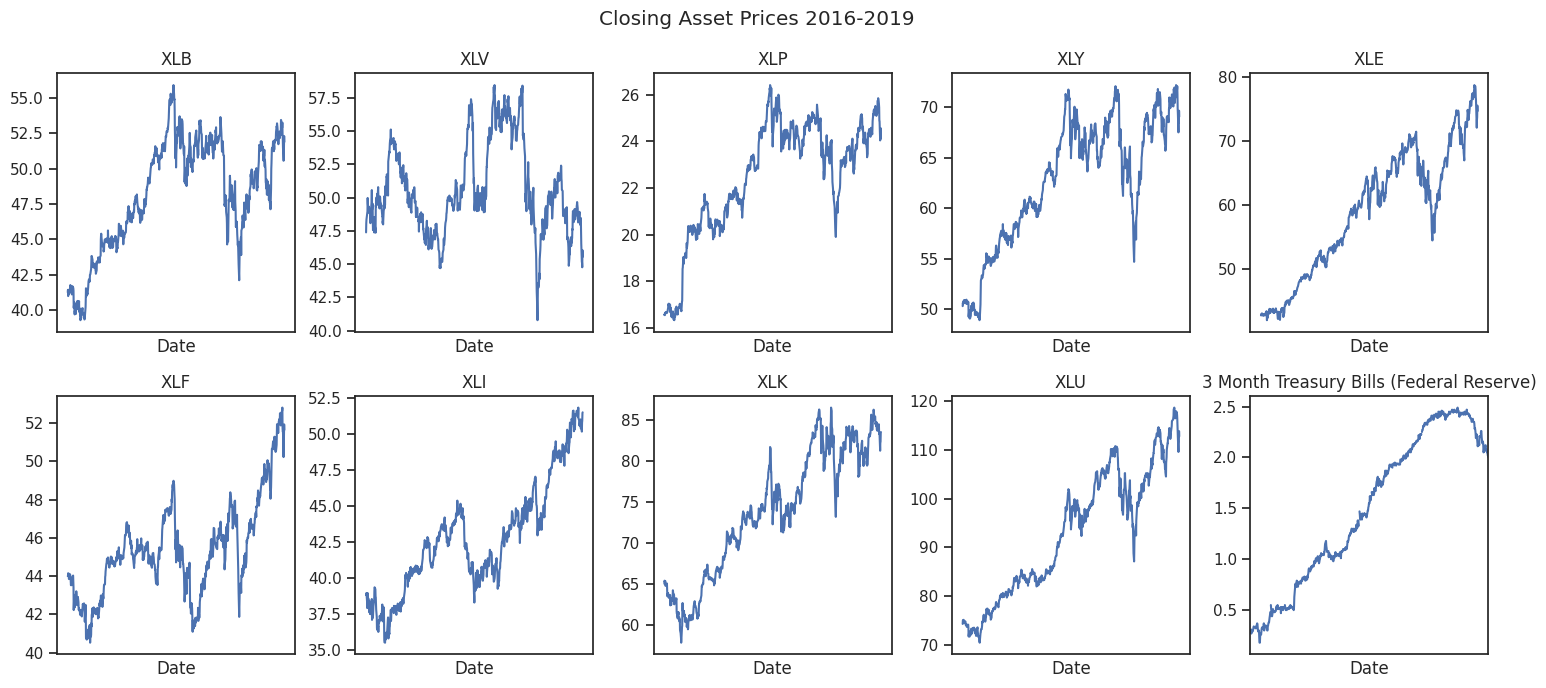

In [81]:
# Plot of the historical prices of the assets and risk-free asset
fig, axes = plt.subplots(2, 5, figsize=(15,7))
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    asset_data[ticker].plot(ax=axes[i], title=f'{ticker}')
    axes[i].set_xlabel('Date')
    axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

fed_data['3MO'].plot(ax=axes[-1], title='3 Month Treasury Bills (Federal Reserve)')
axes[-1].set_xlabel('Date')
axes[-1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
fig.suptitle('Closing Asset Prices 2016-2019')
plt.tight_layout()
plt.show()

## Calculate the returns on the Assets and risk-free asset

                                 XLB        XLV        XLP        XLY  \
Date                                                                    
2016-08-10 00:00:00+00:00  41.251228  47.386620  16.557199  50.308044   
2016-08-11 00:00:00+00:00  41.428989  48.083374  16.591864  50.635727   
2016-08-12 00:00:00+00:00  40.988804  48.350822  16.543329  50.497757   
2016-08-15 00:00:00+00:00  41.403606  48.737915  16.654270  50.834068   
2016-08-16 00:00:00+00:00  41.183506  48.815331  16.612667  50.609863   

                                 XLE        XLF        XLI        XLK  \
Date                                                                    
2016-08-10 00:00:00+00:00  42.736824  43.996937  38.839878  65.001068   
2016-08-11 00:00:00+00:00  42.891430  43.996937  38.931793  65.376045   
2016-08-12 00:00:00+00:00  42.845970  44.149212  38.985416  65.210342   
2016-08-15 00:00:00+00:00  43.055134  44.037014  38.387993  65.323700   
2016-08-16 00:00:00+00:00  42.736824  43.844673  3

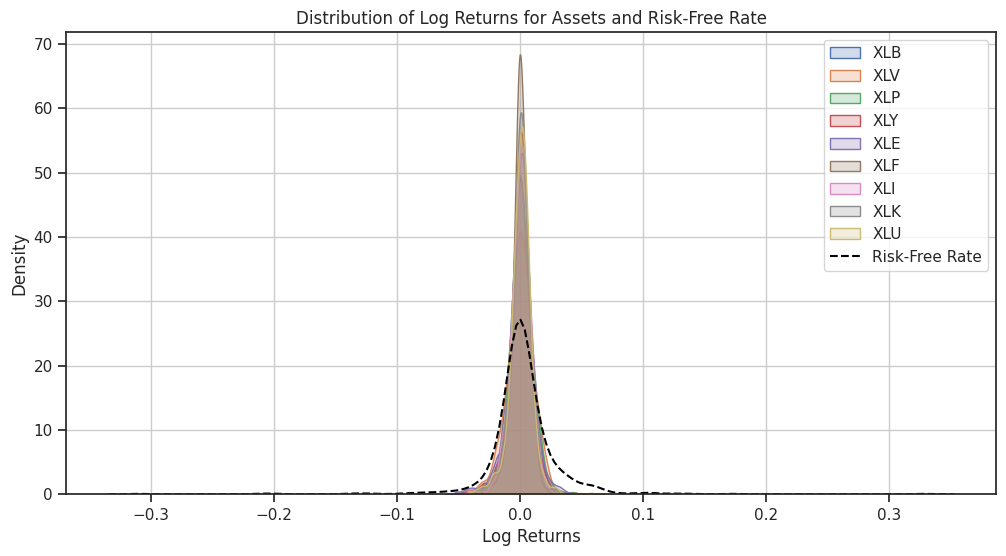

In [68]:
def log_returns(portfolio):
    '''Daily Log Returns'''
    # Calculate the returns of the
    portfolio = portfolio.pct_change().ffill().dropna()
    return np.log(1 + portfolio)

# Calculate the returns of the assets and risk free asset
asset_data.columns = tickers
asset_log_returns =log_returns(asset_data)

# risk free rate (here we will use 3 month Treasury bills)
rf_rate = log_returns(fed_data['3MO'])

print(asset_data.head())
print(rf_rate.head())

## Plot the KDE distribution for all assets
# This helps us visualise whether log returns follow any distribution and identify skewness
plt.figure(figsize=(12,6))

for asset in asset_data.columns:
  sns.kdeplot(asset_log_returns[asset], label=asset, fill=True)

sns.kdeplot(rf_rate, label='Risk-Free Rate', color='black', linestyle='--')
plt.title("Distribution of Log Returns for Assets and Risk-Free Rate")
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

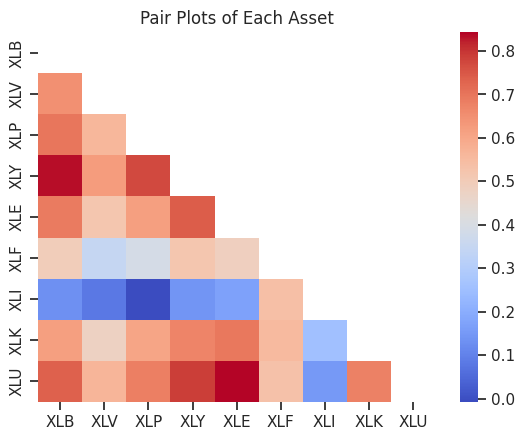

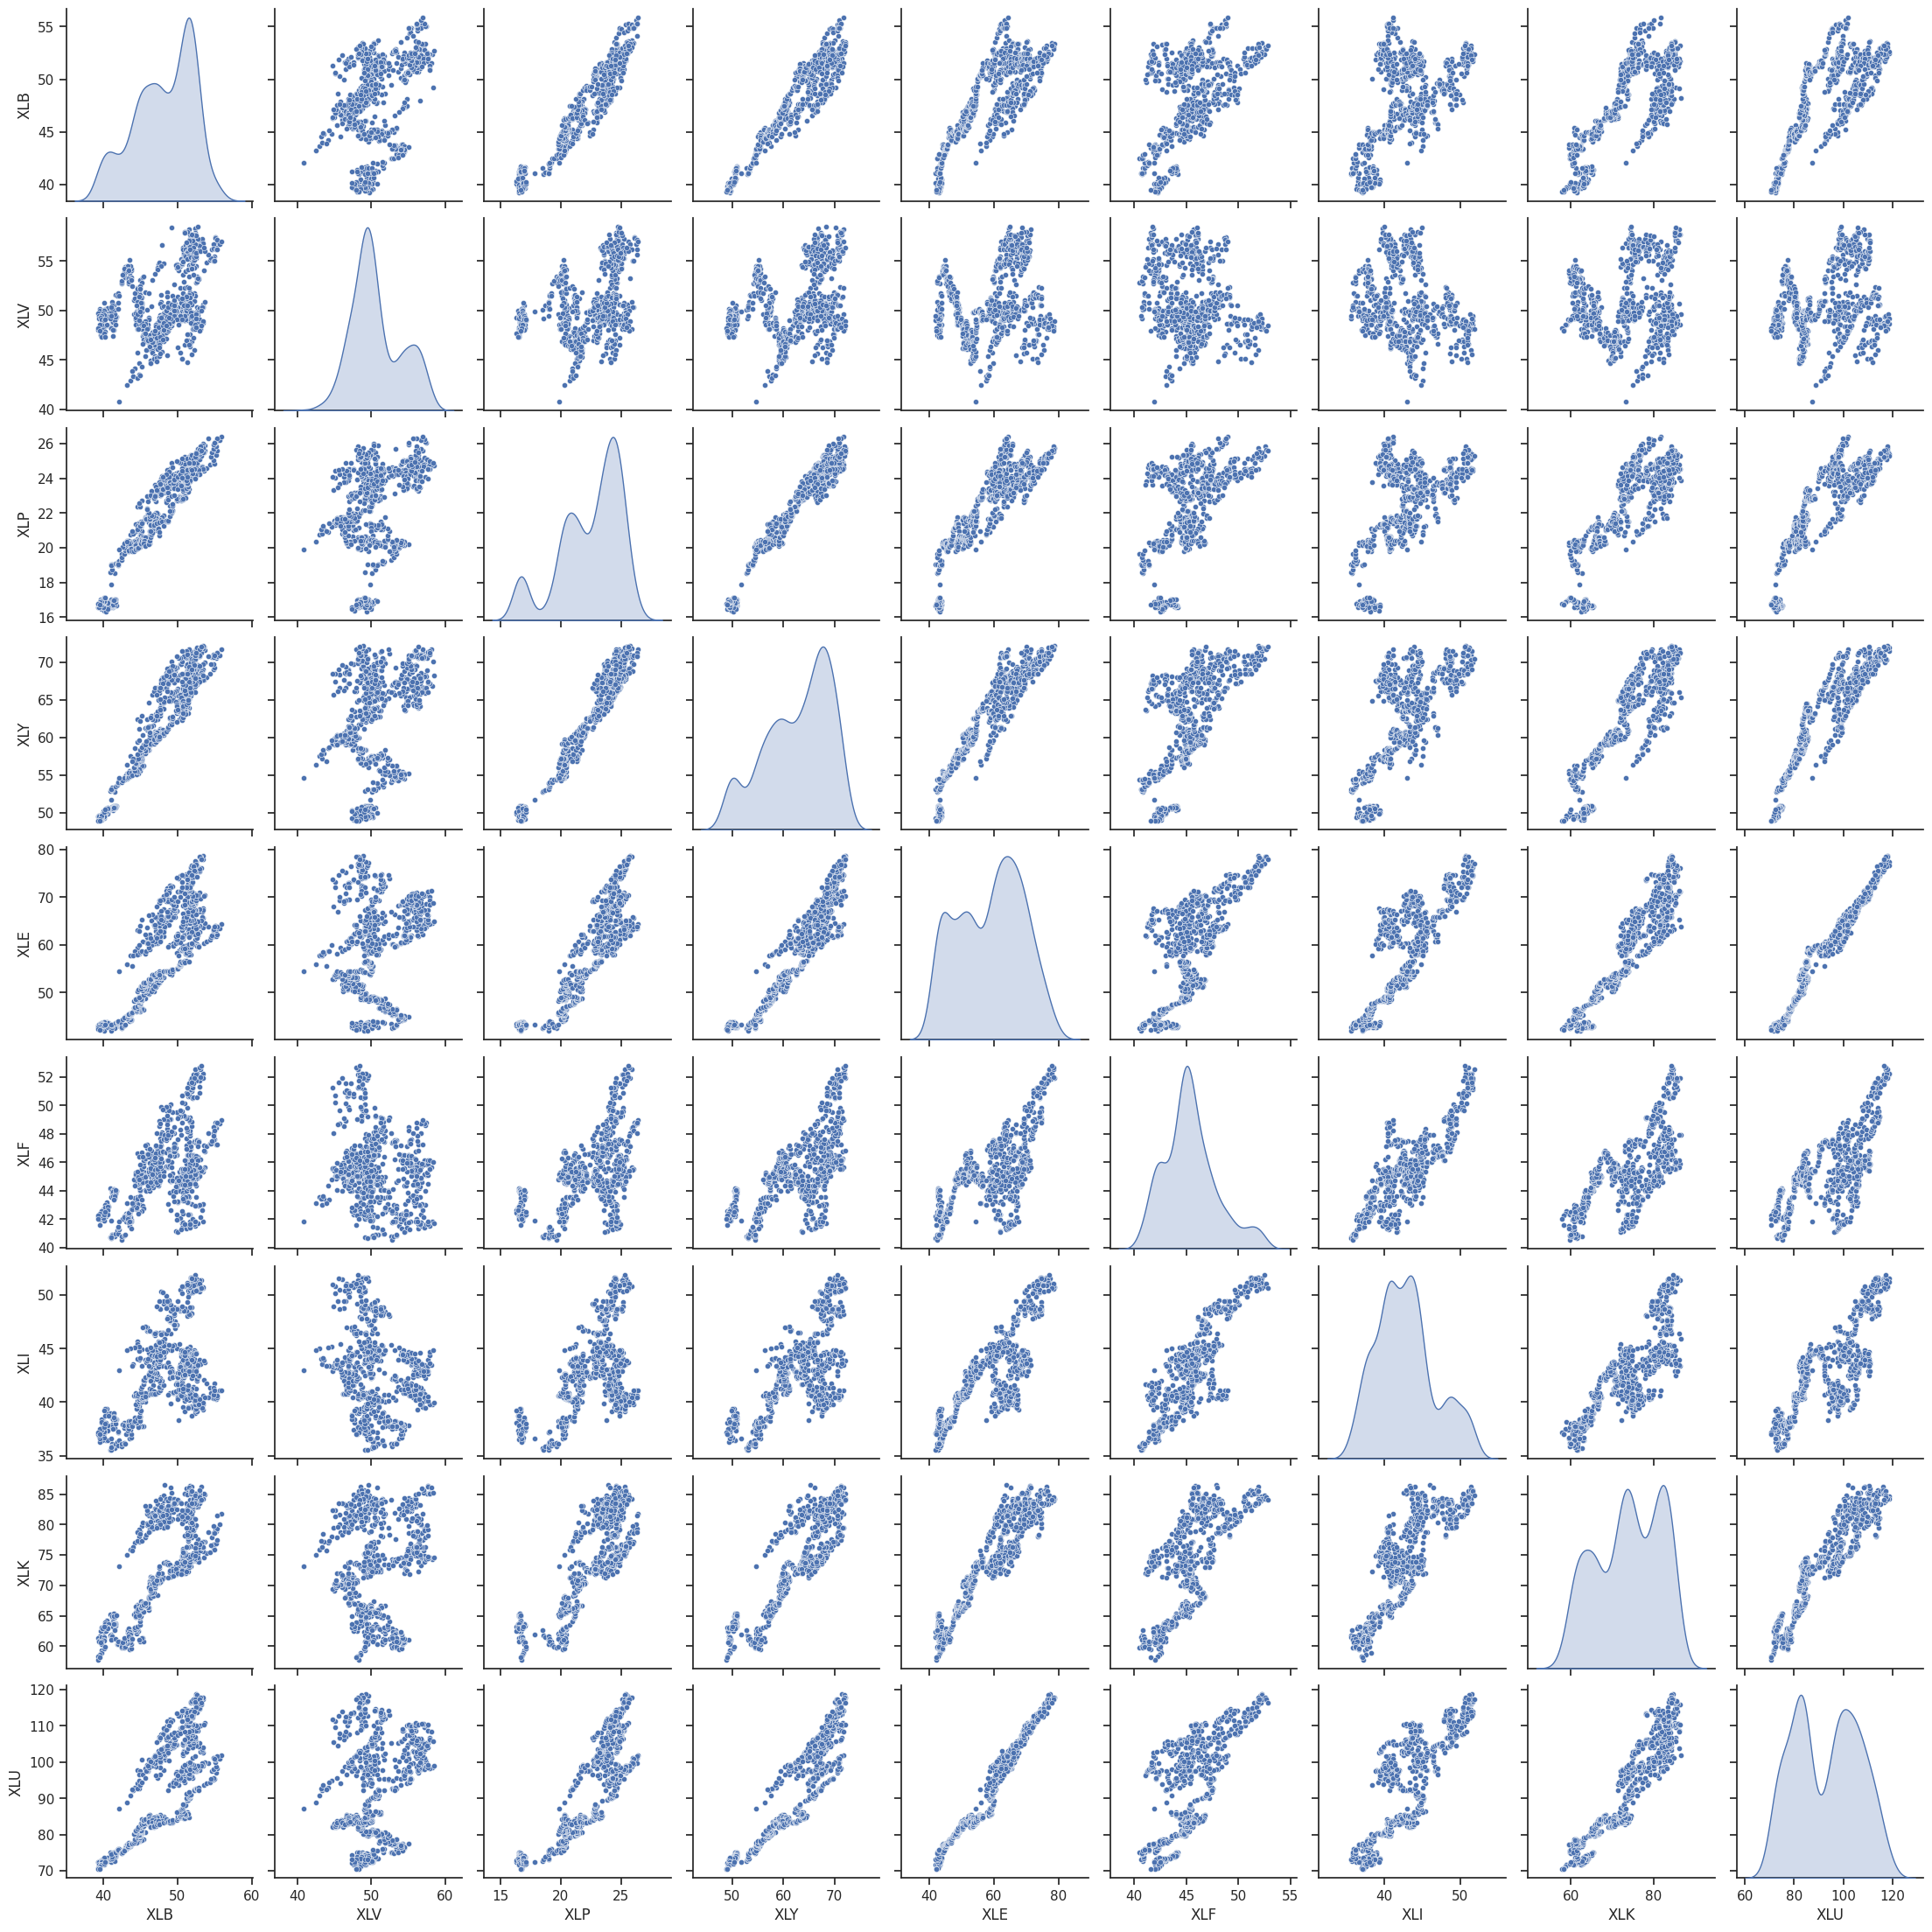

In [69]:
asset_corr = asset_log_returns.corr()
mask = np.zeros_like(asset_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(asset_corr, cmap='coolwarm', mask=mask)
plt.title("Pair Plots of Each Asset Log Returns")
plt.show()

sns.set(font_scale=1)
sns.set(style='ticks', color_codes=True)
sns.pairplot(data=asset_data, vars=asset_data.columns, diag_kind='kde',
              kind='scatter', plot_kws={'s':20})
plt.show()

Here the Industrial sector (XLI) is relatively diversed to the rest of the portfolio, with Consumer Staples Select Sector (XLP) being the most uncorrelated with XLI. All other funds other than XLF are slightly correlated. The Financial Select Sector Fund (XLF) has correlation around 0.4-0.5 to other funds.

Create the Portfolio Weights which will represent our exposure to each asset in our portfolio. In this example, we are only looking at long-trade only portfolio thta is full invested always, meaning the weights will be bounded between 0 and 1, and the weights sum to 1. We will run an additional parameter being the number of simulations we want to run, this will create sims number of columns in our weight matrix.

In [61]:
def portfolio_Weights(num_portfolios: int, num_assets: int):
    ''' Randomly generate the weights that sum to 1 using Dirichlet'''
    return np.random.dirichlet(np.ones(num_assets), num_portfolios)


sims = 100_000 # Number of Monte Carlo Simulations

# Calculate the weights
weights = portfolio_Weights(sims, len(tickers))

print(weights.shape)

(100000, 9)


## Calculate the Mean Variance of the portfolios

The equations and explanations for the mathematics here is presented on the paper written alongside this.

In [62]:
def portfolio_Reward(weights, exp_returns):
    return np.dot(weights.T, exp_returns)

def portfolio_Variance(weights, sigma):
    return weights.T.dot(sigma).dot(weights)

def performance(weights, portfolios, rf_rate, alpha, sigma):

    portfolio_returns = [0] * portfolios # portfolios is the number of simulations
    portfolio_variance = [0] * portfolios
    portfolio_volatility = [0] * portfolios
    portfolio_sharpe = [0] * portfolios
    rf_rate_mean = rf_rate.mean()

    for i in range(portfolios):
        w = weights[i]
        portfolio_returns[i] = portfolio_Reward(w, alpha)
        portfolio_variance[i] = portfolio_Variance(w, sigma)
        portfolio_volatility[i] = np.sqrt(portfolio_variance[i])
        portfolio_sharpe[i] = (portfolio_returns[i] - rf_rate_mean)/portfolio_volatility[i]


    return portfolio_returns, portfolio_variance, portfolio_volatility, portfolio_sharpe


# Calculate the alpha (expected returns) and sigma (returns covariance) adjusted annually
alpha, sigma = asset_log_returns.mean() * 252, asset_log_returns.cov() * 252


portfolio_returns, portfolio_variance, portfolio_volatility, portfolio_sharpe = performance(weights,
                                                                                            sims,
                                                                                            rf_rate,
                                                                                            alpha,
                                                                                            sigma)

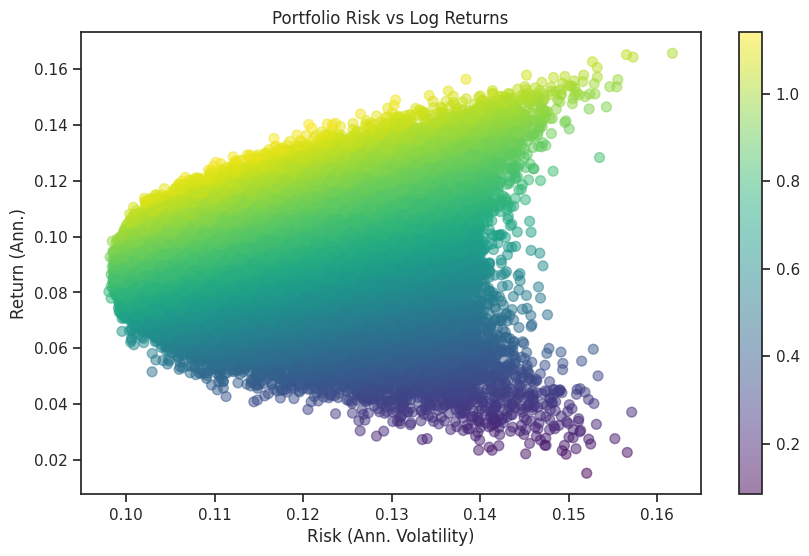

In [63]:
def feasible_Set(portfolio_returns, portfolio_volatility, portfolio_sharpe):
    plt.figure(figsize=(10,6))
    plt.scatter(portfolio_volatility, portfolio_returns, alpha=0.5, s=50, c=portfolio_sharpe, cmap='viridis', marker='o')
    plt.colorbar()
    plt.title("Portfolio Risk vs Log Returns")
    plt.xlabel("Risk (Ann. Volatility)")
    plt.ylabel("Return (Ann.)")
    plt.show()

# Scatter plot of Risk/Reward of all simulations
feasible_Set(portfolio_returns, portfolio_volatility, portfolio_sharpe)

## Efficient Frontier Curve

The Efficient Frontier is the of optimial portfolios that offer the highest expected return for a defined level of risk. It can also be defined as: the optimial portfolios that offer the lowest level of risk for a defined level of returns. Here we have plotted it as a black line.

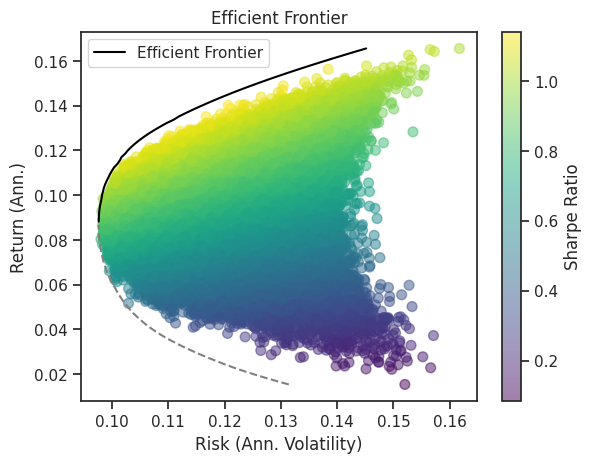

In [64]:
def efficient_Frontier(portfolio_returns, portfolio_volatility, portfolio_sharpe,
                 tickers, alpha, sigma):
    '''
    We will not take into account borrowing (weights outside [0, 1]), i.e. we are long-only,
    fully invested portfolio. As a result, the best method to optimise the risk/return is to
    use SLSQP, a gradient-based optimisation algorithm, as it is efficient for smooth objective
    functions with constraints. Additionally, SLSQP is best because it handles nonlinear
    optimisations well.
    '''
    results_volatility = []
    results_weights = []
    target_returns = np.linspace(min(portfolio_returns), max(portfolio_returns), 100)
    bounds = Bounds(0, 1) # no short-selling, only long-trades
    initial_return = [1 / len(tickers)]*len(tickers)

    for target_return in target_returns:
        # constraints we want to minimise for the SLSQP
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                       {'type': 'eq', 'fun': lambda weights: portfolio_Reward(weights, alpha) - target_return})

        efficient_results = minimize(portfolio_Variance, initial_return, method='SLSQP',
                           args=(sigma,), bounds=bounds, constraints=constraints)

        volatility = np.sqrt(efficient_results.fun)#np.sqrt(portfolio_Variance(efficient_results.x, sigma))
        weights = efficient_results.x#portfolio_Reward(efficient_results.x, alpha)

        results_volatility.append(volatility)
        results_weights.append(weights)


    min_volatility_index = np.argmin(results_volatility)

    efficient_volatility = results_volatility[min_volatility_index:]
    efficient_returns = target_returns[min_volatility_index:]

    inefficient_volatility = results_volatility[:min_volatility_index]
    inefficient_returns = target_returns[:min_volatility_index]

    # Efficient Frontier plot
    plt.scatter(portfolio_volatility, portfolio_returns, alpha=0.5, s=50, c=portfolio_sharpe, cmap='viridis', marker='o')

    # Efficient Frontier Curve
    plt.plot(efficient_volatility, efficient_returns, color='black', label='Efficient Frontier')

    # Inefficient Frontier Curve
    plt.plot(inefficient_volatility, inefficient_returns, color='grey', linestyle='--')

    plt.colorbar(label='Sharpe Ratio')
    plt.title("Efficient Frontier")
    plt.xlabel("Risk (Ann. Volatility)")
    plt.ylabel("Return (Ann.)")
    plt.legend()
    plt.show()

    return efficient_volatility, efficient_returns

# Calculates the Efficient Frontier points
optimial_volatility, optimial_weights = efficient_Frontier(portfolio_returns, portfolio_volatility,
                   portfolio_sharpe,tickers, alpha, sigma)